In [1]:
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2we0ptwr
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-2we0ptwr
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2a46981c5eeccf56426a9fdca96f3d3754bced9a_-cp37-none-any.whl size=258364 sha256=5692759e52e28241aae479ac6a5e9833ec7c4c5b0130c52ebe77b60b7891fe66
  Stored in directory: /tmp/pip-ephem-wheel-cache-ueim5259/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from IPython.display import clear_output
tf.executing_eagerly()
from keras.optimizers import Adam

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMGTBBP/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMGTBBP/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

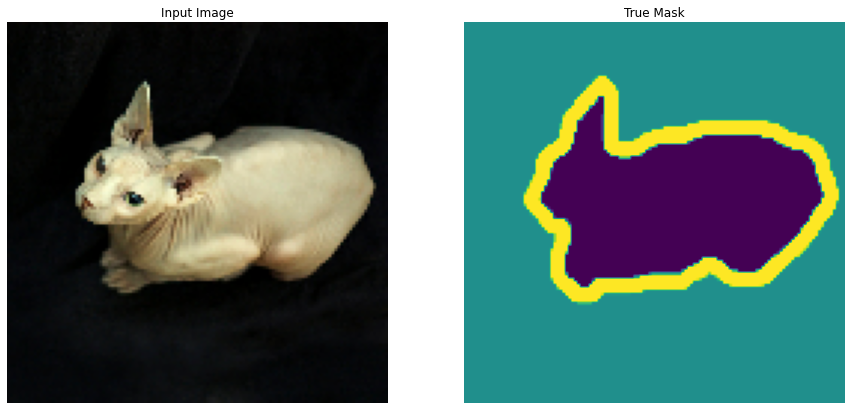

In [11]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [12]:
OUTPUT_CHANNELS = 3

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

 # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model1 = unet_model(OUTPUT_CHANNELS)


9412608/9406464 [==============================] - 0s 0us/step


In [15]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

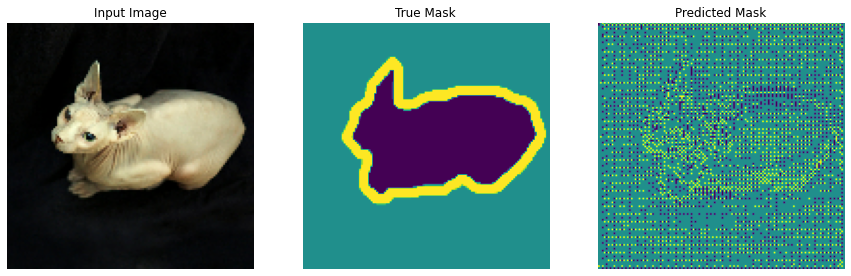

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model1.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model1.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [17]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

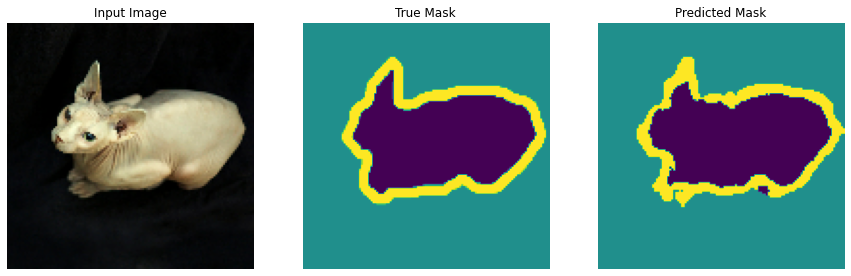


Sample Prediction after epoch 50



In [22]:
model1_history = model1.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [23]:
accuracy2 = model1_history.history['accuracy']
val_accuracy2 = model1_history.history['val_accuracy']
print('training accuracy',np.mean(accuracy2) * 100,'%')
print('validation_accuracy',np.mean(val_accuracy2) * 100,'%')

training accuracy 94.0492571592331 %
validation_accuracy 88.71194303035736 %


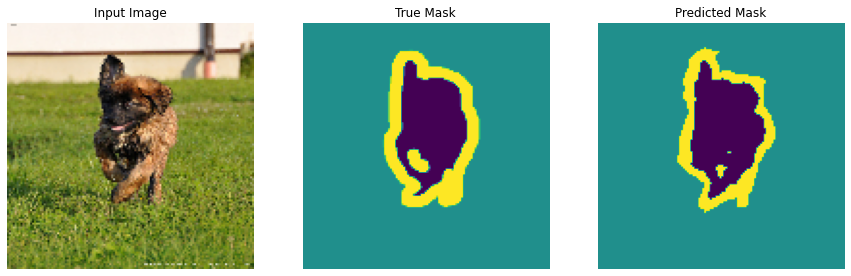

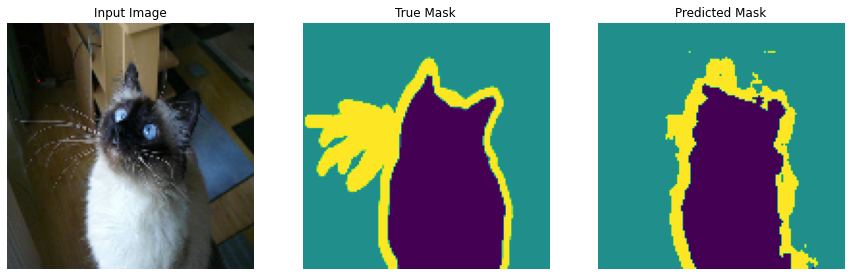

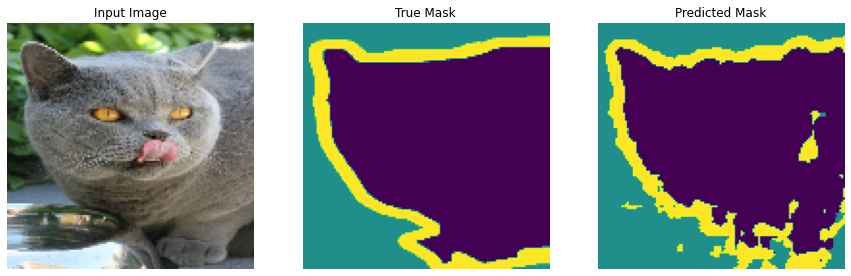

In [24]:
show_predictions(test_dataset, 3)

In [ ]:
#=====================build the cnn model here===============================
model = tf.keras.Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu',strides =(2,2),padding='same',input_shape = (128,128,3)))
model.add(Conv2D(32,kernel_size=3, activation='relu',strides=(1,1),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides =None ,padding='valid'))
model.add(Conv2D(64,kernel_size=3, strides=(1,1),activation='relu',padding='same',))
model.add(Conv2DTranspose(64,kernel_size=3,activation='relu',padding='same',strides=(2,2)))
model.add(Conv2DTranspose(3,kernel_size=3,activation='softmax',padding='same',strides=(2,2),dilation_rate=(1,1)))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 3)       1731      
Total params: 62,243
Trainable params: 62,243
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

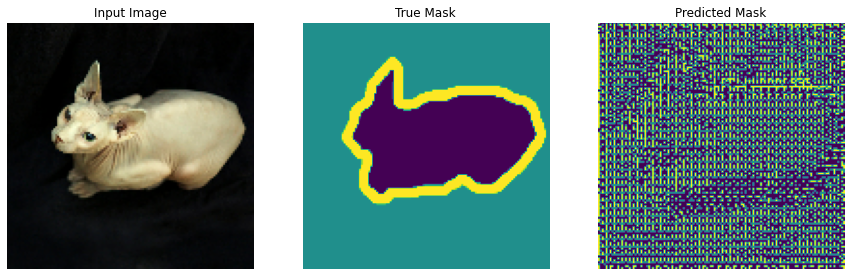

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [31]:
print(VALIDATION_STEPS)

22


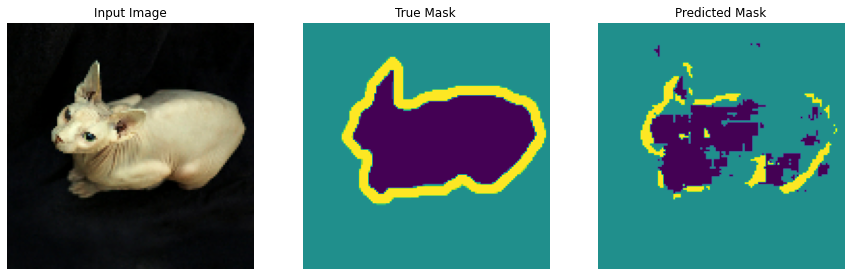


Sample Prediction after epoch 50



In [32]:
model_history = model.fit(train_dataset, epochs=EPOCHS,verbose=1,validation_freq=1,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [34]:
accuracy1 = model_history.history['accuracy']
val_accuracy1 = model_history.history['val_accuracy']
print('training accuracy',np.mean(accuracy1) * 100,'%')
print('validation_accuracy',np.mean(val_accuracy1) * 100,'%')

training accuracy 78.21864759922028 %
validation_accuracy 78.16767358779907 %


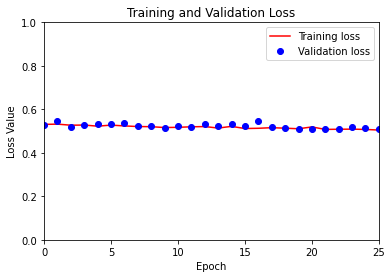

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.xlim([0,25])
plt.legend()
plt.show()

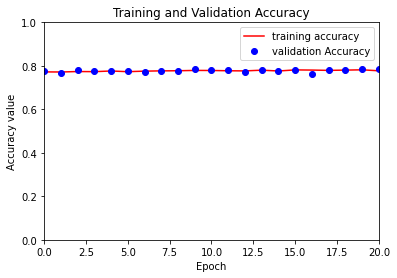

In [36]:
accuracy = model_history.history['accuracy']
val_accuracy =model_history.history['val_accuracy']
plt.figure()
plt.plot(epochs, accuracy,'r', label ='training accuracy')
plt.plot(epochs,val_accuracy,'bo', label = 'validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.ylim([0, 1])
plt.xlim([0,20])
plt.legend()
plt.show()

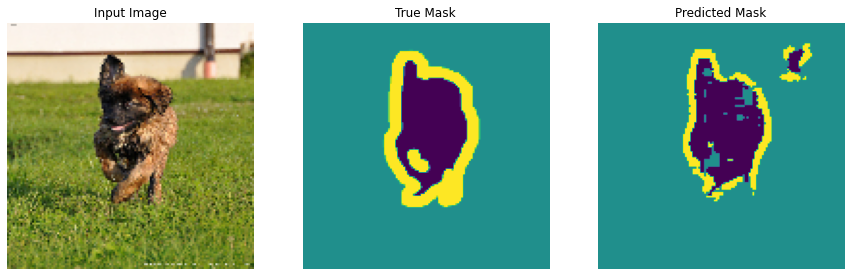

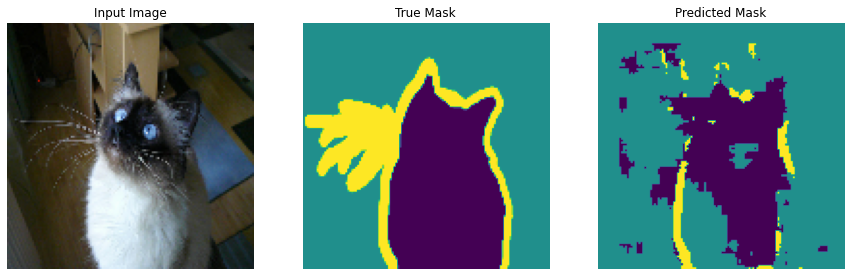

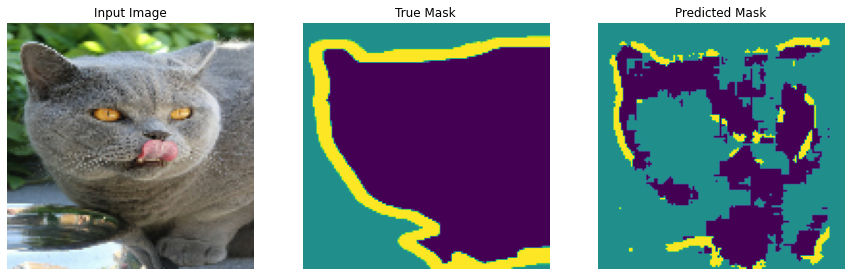

In [37]:
show_predictions(test_dataset, 3)